# The Distribution of Wealth and the MPC


This notebook presents a selection of results from the paper [The Distribution of Wealth and the Marginal Propensity to Consume](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), using the [Econ-ARK/HARK](https://github.com/econ-ark/HARK) toolkit. It sketches the steps that would need to be taken to solve the model using the [dolARK](https://github.com/EconForge/dolARK) modeling system.


In [1]:
# This cell does some standard python setup!

import code.calibration as parameters
import warnings  # The warnings package allows us to ignore some harmless but alarming warning messages
from code.calibration import SCF_wealth, SCF_weights
from code.estimation import estimate

# Import related generic python packages
import matplotlib.pyplot as plt  # Plotting tools
import numpy as np
from HARK.utilities import get_lorenz_shares

warnings.filterwarnings("ignore")


def mystr(number):
    return f"{number:.4f}"

## Abstract

In a model calibrated to match micro- and macroeconomic evidence on household income dynamics, this paper shows that a modest degree of heterogeneity in household preferences or beliefs is sufficient to match empirical measures of wealth inequality in the U.S. The hegerogeneity-augmented model's predictions are consistent with microeconomic evidence that suggests that the annual marginal propensity to consume (MPC) is much larger than the roughly 0.04 implied by commonly-used macroeconomic models (even ones including some heterogeneity). The high MPC arises because many consumers hold little wealth despite having a strong precautionary motive. The model also plausibly predicts that the aggregate MPC can differ greatly depending on how the shock is distributed across households (depending, e.g., on their wealth, or employment status).


## Notation For the Core Model

We define the following notation.

|    Exogenous Random Variable     | Description       | Code            | Value |
| :------------------------------: | ----------------- | --------------- | :---: |
| $\newcommand{\tshk}{\zeta}\tshk$ | Transitory Income | $\texttt{tshk}$ |       |
| $\newcommand{\pshk}{\psi}\pshk$  | Permanent Shock   | $\texttt{pshk}$ |       |

|                Parameter                 | Description                          | Code                  |  Value  |
| :--------------------------------------: | ------------------------------------ | --------------------- | :-----: |
| $\newcommand{\PLives}{\Lambda} \PLives$  | Probability of living                | $\texttt{PLives}$     | 0.99375 |
| $\newcommand{\Discount}{\beta}\Discount$ | Time Preference Factor               | $\texttt{Discount}$   |  0.96   |
|     $\newcommand{\CRRA}{\rho}\CRRA$      | Coeﬃcient of Relative Risk Aversion  | $\texttt{CRRA}$       |    1    |
|              $\sigma_\tshk$              | Transitory Income Standard Deviation | $\texttt{PermShkStd}$ |   0.1   |
|              $\sigma_\pshk$              | Permanent Shock Standard Deviation   | $\texttt{TranShkStd}$ |   0.1   |

|                 Variable                  | Description         | Code                |
| :---------------------------------------: | ------------------- | ------------------- |
|       $\newcommand{\aRat}{a}\aRat$        | Assets              | $\texttt{aRat}$     |
|       $\newcommand{\mRat}{m}\mRat$        | Market resources    | $\texttt{mRt}$      |
|       $\newcommand{\KLev}{K}\KLev$        | Capital Aggregate   | $\texttt{KLev}$     |
| $\newcommand{\kapShare}{\alpha}\kapShare$ | Capital share       | $\texttt{kapShare}$ |
|       $\newcommand{\LLev}{L}\LLev$        | Labor Aggregate     | $\texttt{LLev}$     |
|     $\newcommand{\labor}{\ell}\labor$     | Labor share         | $\texttt{labor}$    |
|       $\newcommand{\kRat}{k}\kRat$        | $K/P$               | $\texttt{kRat}$     |
|       $\newcommand{\pRat}{p}\pRat$        | Permanent Income    |                     |
|               $\mathbf{P}$                |                     |                     |
|      $\newcommand{\rProd}{r}\rProd$       | Interest rate       | $\texttt{rProd}$    |
|       $\newcommand{\yLev}{y} \yLev$       | Income              | $\texttt{yLev}$     |
|       $\newcommand{\Wage}{W}\Wage$        | Aggregate Wage Rate | $\texttt{Wage}$     |

|                 Functions                 | Description | Code             | Value |
| :---------------------------------------: | ----------- | ---------------- | :---: |
|  $\newcommand{\cFunc}{\mathrm{c}}\cFunc$  | Consumption | $\texttt{cFunc}$ |       |
| $\newcommand{\valfn}{\mathrm{v}} \valfn$  | Value       | $\texttt{valfn}$ |
| $\newcommand{\uFunc}{{\mathrm{u}}}\uFunc$ | Utility     | $\texttt{uFunc}$ |       |

$\newcommand{\cRat}{c}$
$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\PDies}{\mathsf{P}}$
$\newcommand{\ptyLev}{a}$
$\newcommand{\YLev}{Y}$
$\newcommand{\wEndRat}{\aRat}$


The consumer has a standard Constant Relative Risk Aversion utility function $$u(c)=\frac{c^{1-\rho}}{1-\rho}$$


The idiosyncratic (household) income process is logarithmic Friedman:
\begin{align*}
\yLev_{t+1} & = \pRat_{t+1}\tshk_{t+1}\Wage\\
\pRat_{t+1} & = \pRat_{t}\pshk_{t+1}
\end{align*}


The Bellman form of the value function for households is:

\begin{align*}
\valfn(\mRat_{t}) & = \underset{\cFunc_{t}}{\max } ~~ \uFunc(\cFunc_{t}(\mRat_{t}))+\Discount \PLives \Ex_{t}\left[ \pshk_{t+1}^{1-\CRRA}\valfn(\mRat_{t+1})
\right] \\
\notag & \text{s.t.}\\
\wEndRat_{t} & = \mRat_{t}-\cRat_{t},\\
\wEndRat_{t} & \geq0, \\
\kRat_{t+1} & = \wEndRat_{t}/(\PLives \pshk_{t+1}),
\\
\mRat_{t+1} & = (\daleth +\rProd_{t})\kRat_{t+1}+\tshk_{t+1},\\
\rProd & = \kapShare\ptyLev(\KLev/\labor\LLev)^{\kapShare-1}\\
\end{align*}


In [2]:
"""
This will run the absolute minimum amount of work that actually produces
relevant output-- no aggregate shocks, perpetual youth, matching net worth.
Will run both beta-point and beta-dist versions.
"""

"""
Copied here from do_min.py.
Design decisions about whether to include this code explicitly,
or import it, or execute it as is here, TBD.
"""

'\nCopied here from do_min.py.\nDesign decisions about whether to include this code explicitly,\nor import it, or execute it as is here, TBD.\n'

In [3]:
# For speed here, use the "tractable" version of the model
# This is not the "right" model, but illustrates the key point
"""
This options file specifies parameter heterogeneity, making the choice in the paper:
uniformly distributed discount factors.
"""
param_name = "DiscFac"  # Which parameter to introduce heterogeneity in
dist_type = "uniform"  # Which type of distribution to use

"""
This options file specifies the "standard" work options for cstwMPC, estimating the model only.
"""
run_estimation = True  # Runs the estimation if True
# Choose which sensitivity analyses to run: rho, xi_sigma, psi_sigma, mu, urate, mortality, g, R
run_sensitivity = [False, False, False, False, False, False, False, False]
# Computes K/Y ratio for a wide range of beta; should have do_beta_dist = False
find_beta_vs_KY = False
# Uses a "tractable consumer" rather than solving full model when True
do_tractable = True

# Solve for the $\beta-Point$ (do_param_dist=False) for speed
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""

do_param_dist = False  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
# Matches liquid assets data when True, net worth data when False
do_liquid = False

Beginning an estimation with the specification name PYUnifbetaPointIndNetWorth...
get_KY_ratio_difference tried center = 0.95 and got -2.980471591088475
get_KY_ratio_difference tried center = 0.995 and got 1.997155517846061
get_KY_ratio_difference tried center = 0.9769448109839811 and got -2.3081130220958577
get_KY_ratio_difference tried center = 0.9866244433919603 and got -1.216028776433893
get_KY_ratio_difference tried center = 0.9897941706535301 and got 0.303456962113164
get_KY_ratio_difference tried center = 0.9891611434515486 and got 0.024231098773936477
get_KY_ratio_difference tried center = 0.989107374037012 and got -0.0010138086477762265
get_KY_ratio_difference tried center = 0.9891095333595451 and got 4.311107538068626e-06
get_KY_ratio_difference tried center = 0.9891090333595447 and got -0.00023140282526235012
Estimate is center=0.9891095333595451, spread=0.0, took 44.62666606903076 seconds.
Running in interactive shell (Jupyter notebook or spyder)


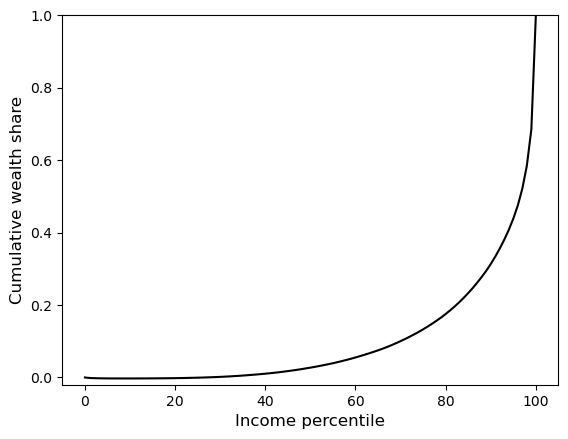

Estimate is center=0.9891095333595451, spread=0.0
Lorenz distance is 42.02894388233986
Average MPC for all consumers is 0.099
Average MPC in the top percentile of W/Y is 0.069
Average MPC in the top decile of W/Y is 0.071
Average MPC in the top quintile of W/Y is 0.072
Average MPC in the second quintile of W/Y is 0.074
Average MPC in the middle quintile of W/Y is 0.074
Average MPC in the fourth quintile of W/Y is 0.076
Average MPC in the bottom quintile of W/Y is 0.197
Average MPC in the top percentile of y is 0.075
Average MPC in the top decile of y is 0.078
Average MPC in the top quintile of y is 0.084
Average MPC in the second quintile of y is 0.117
Average MPC in the middle quintile of y is 0.118
Average MPC in the fourth quintile of y is 0.082
Average MPC in the bottom quintile of y is 0.093
Average MPC for the employed is 0.096
Average MPC for the unemployed is 0.130
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
65.397% are in the bottom wealth

In [4]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
}


EstimationEconomy = estimate(options, parameters)

In [5]:
MyGuys = EstimationEconomy.agents[0]
MyGuys.check_conditions()
print(MyGuys.bilt["conditions_report"])

β=0.98911 : intertemporal discount factor (DiscFac)
R=1.01635 : risk free interest factor (Rfree)
G=1.00000 : permanent income growth factor (PermGroFac)
ρ=1.01000 : coefficient of relative risk aversion (CRRA)
ℒ=0.99375 : survival probability (LivPrb)
Þ=(βℒR)^(1/ρ)=0.99901 : absolute patience factor (APFac)
℘=0.01400 : probability of worst income shock realization (WorstPrb)

APFac=0.99901 : The Absolute Patience Factor satisfies the Absolute Impatience Condition (AIC) Þ < 1.
RPFac=0.98294 : The Return Patience Factor satisfies the Return Impatience Condition (RIC) Þ/R < 1.
WRPFac=0.01436 : The Weak Return Patience Factor satisfies the Weak Return Impatience Condition (WRIC) ℘ Þ/R < 1.
GPFacRaw=0.99901 : The Growth Patience Factor satisfies the Growth Impatience Condition (GICRaw) Þ/G < 1.
GPFacMod=1.00227 : The Risk-Modified Growth Patience Factor violates the Risk-Modified Growth Impatience Condition (GICMod) Þ/(G‖Ψ‖_(-1)) < 1.
GPFacLiv=0.99277 : The Mortality-Adjusted Growth Patien

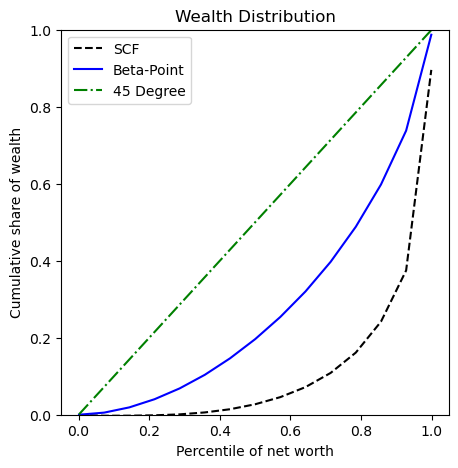

In [6]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = EstimationEconomy.reap_state["aLvl"][0]
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Point")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_1")

In [7]:
print(sim_wealth.shape)

(10000,)


In [8]:
print(EstimationEconomy.agents)

[<code.agents.DoWAgent object at 0x14a653b5ca0.
Parameters:
cycles: 0
CRRA: 1.01
Rfree: 1.0163522012578616
DiscFac: 0.9891095333595451
LivPrb: [0.99375]
PermGroFac: [1.0]
BoroCnstArt: 0.0
MaxKinks: 400
AgentCount: 10000
aNrmInitMean: -11.512925464970229
aNrmInitStd: 0.0
pLvlInitMean: 0.0
pLvlInitStd: 0.0
PermGroFacAgg: 1.0
T_age: 400
T_cycle: 1
PerfMITShk: False
aXtraMin: 1e-05
aXtraMax: 20
aXtraNestFac: 3
aXtraCount: 20
aXtraExtra: [None]
PermShkStd: [0.06030226891555272]
PermShkCount: 5
TranShkStd: [0.2]
TranShkCount: 5
UnempPrb: 0.07
UnempPrbRet: None
IncUnemp: 0.15
IncUnempRet: None
tax_rate: 0.0
T_retire: 0
vFuncBool: False
CubicBool: False
neutral_measure: False
NewbornTransShk: False
PopGroFac: 1.0
T_sim: 1200
IndL: 1.1111111111111112>]


## Time Preference Heterogeneneity

Our specific approach is to replace the assumption that all households have the same time
preference factor with an assumption that, for some dispersion $\nabla$, time
preference factors are distributed uniformly in the population between
$\grave{\Discount}-\nabla$ and $\grave{\Discount}+\nabla$ (for this reason, the model is referred to as the $\Discount$-Dist model). Then,
using simulations, we search for the values of $\grave{\Discount}$ and
$\nabla$ for which the model best matches the fraction of net worth held by the top $20$, $40$, $60$, and $80$ percent of the population, while at the same time matching
the aggregate capital-to-output ratio from the perfect foresight
model. Specifically, defining $w_{i}$ and $\omega _{i}$ as the proportion of total aggregate net worth held by the top $i$ percent in our model and in the data, respectively, we solve the following minimization problem:

$$
\{\grave{\Discount}, \nabla\}= \underset{\{{\Discount}, \nabla\}}{\text{argmin} }\Big(\sum_\text{i=20, 40, 60, 80}
  \big(w_{i}({\Discount}, \nabla)-\omega _{i}\big)^{2}\Big)^{1/2}
$$

subject to the constraint that the aggregate wealth (net worth)-to-output ratio in the model matches the aggregate
capital-to-output ratio from the perfect foresight model ($\KLev_{PF}/\YLev_{PF}$). When solving the problem for the FBS specification we shut down the aggregate shocks (practically, this does not affect the estimates given their small size).

$$\KLev / \YLev = \KLev_{PF} / \YLev_{PF}$$

The solution to this problem is $\{\grave{\Discount}, \nabla\}=\{0.9867, 0.0067\}$
, so that the discount factors are evenly spread roughly between 0.98 and 0.99. We call the optimal value of the objective function the 'Lorenz distance' and use it as a measure of fit of the models.

The introduction of even such a relatively modest amount of time
preference heterogeneity sharply improves the model's fit to the targeted
proportions of wealth holdings, bringing it reasonably in line with the data.


In [9]:
"""
This options file establishes the second simplest model specification possible:
with heterogeneity, no aggregate shocks, perpetual youth model, matching net worth.
"""
do_param_dist = True  # Do param-dist version if True, param-point if False
do_lifecycle = False  # Use lifecycle model if True, perpetual youth if False
do_agg_shocks = False  # Solve the FBS aggregate shocks version of the model
do_liquid = False  # Matches liquid assets data when True, net worth data when False
do_tractable = False  #

Beginning an estimation with the specification name PYUnifbetaDistIndNetWorth...


get_KY_ratio_difference tried center = 0.9867 and got -0.027981685838680104
find_lorenz_distance_at_target_KY tried spread = 0.0067 and got 8.571461336506975
get_KY_ratio_difference tried center = 0.9867000100000001 and got -0.02797827291809485
find_lorenz_distance_at_target_KY tried spread = 0.0067 and got 8.571445407834872
get_KY_ratio_difference tried center = 0.9867 and got -0.027979635266987657
find_lorenz_distance_at_target_KY tried spread = 0.00670001 and got 8.57142195333361
get_KY_ratio_difference tried center = 0.995 and got 2.7330865328513814
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 2.2529243519172324
get_KY_ratio_difference tried center = 0.99499999 and got 2.733083615718669
find_lorenz_distance_at_target_KY tried spread = 0.008 and got 2.2529157441684315
get_KY_ratio_difference tried center = 0.995 and got 2.733084886267814
find_lorenz_distance_at_target_KY tried spread = 0.00799999 and got 2.2529029113743224
get_KY_ratio_difference tried center = 0.9

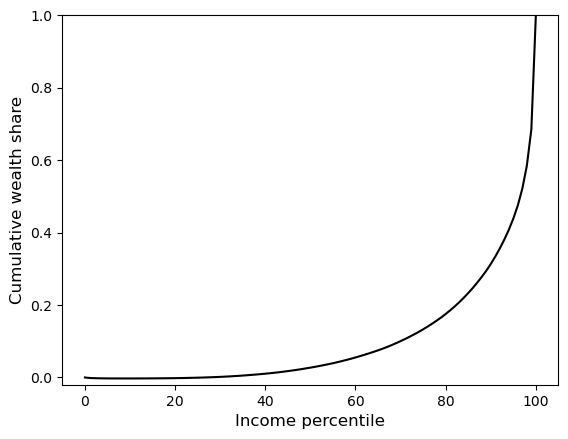

Estimate is center=0.9884057464707907, spread=0.008
Lorenz distance is 2.845361007823885
Average MPC for all consumers is 0.167
Average MPC in the top percentile of W/Y is 0.045
Average MPC in the top decile of W/Y is 0.049
Average MPC in the top quintile of W/Y is 0.052
Average MPC in the second quintile of W/Y is 0.065
Average MPC in the middle quintile of W/Y is 0.096
Average MPC in the fourth quintile of W/Y is 0.197
Average MPC in the bottom quintile of W/Y is 0.424
Average MPC in the top percentile of y is 0.148
Average MPC in the top decile of y is 0.149
Average MPC in the top quintile of y is 0.153
Average MPC in the second quintile of y is 0.179
Average MPC in the middle quintile of y is 0.179
Average MPC in the fourth quintile of y is 0.148
Average MPC in the bottom quintile of y is 0.174
Average MPC for the employed is 0.160
Average MPC for the unemployed is 0.252
Average MPC for the retired is nan
Of the population with the 1/3 highest MPCs...
55.810% are in the bottom weal

In [10]:
options = {
    "param_name": param_name,
    "dist_type": dist_type,
    "run_estimation": run_estimation,
    "run_sensitivity": run_sensitivity,
    "find_beta_vs_KY": find_beta_vs_KY,
    "do_tractable": do_tractable,
    "do_param_dist": do_param_dist,
    "do_lifecycle": do_lifecycle,
    "do_agg_shocks": do_agg_shocks,
    "do_liquid": do_liquid,
    "do_combo_estimation": True,
}


EstimationEconomy = estimate(options, parameters)

In [11]:
# Construct the Lorenz curves and plot them

pctiles = np.linspace(0.001, 0.999, 15)
SCF_Lorenz_points = get_lorenz_shares(
    SCF_wealth, weights=SCF_weights, percentiles=pctiles
)

sim_wealth = np.asarray(EstimationEconomy.reap_state["aLvl"]).flatten()
sim_Lorenz_points = get_lorenz_shares(sim_wealth, percentiles=pctiles)

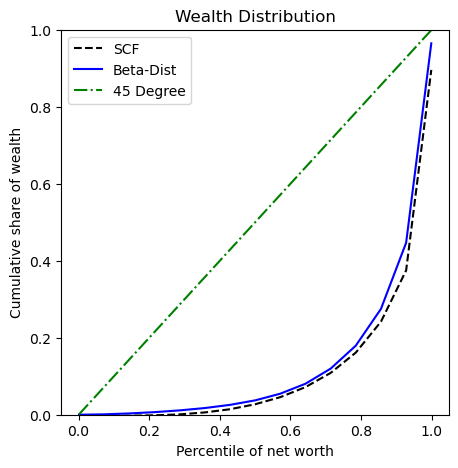

In [12]:
# Plot
plt.figure(figsize=(5, 5))
plt.title("Wealth Distribution")
plt.plot(pctiles, SCF_Lorenz_points, "--k", label="SCF")
plt.plot(pctiles, sim_Lorenz_points, "-b", label="Beta-Dist")
plt.plot(pctiles, pctiles, "g-.", label="45 Degree")
plt.xlabel("Percentile of net worth")
plt.ylabel("Cumulative share of wealth")
plt.legend(loc=2)
plt.ylim([0, 1])
plt.show("wealth_distribution_2")